**By Edwin Tembo, Master's Candidate, Harvard Extension School , ALM, Data Science, December 2025.**

This notebook is one of many used as part of our Data Science Capstone Project for the Harvard Extension School's Data Science Master's Degree Program (ALM).

We explore how a simple Lexicon-Based Approach, part of which is used in the Federal Reserve Bank of San Francisco's  Daily Sentiment Index (https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/)

We also conduct some Exploratory Data Analysis using word clouds and term frequency charts.

AI Usage Notice:

AI was used to generate some starter code, for code review and formatting (PEP-8).

**Components**

**Open Source Methods for Sentiment Analysis**.
 - Lexicon Based FRBSF Daily Sentiment Index

#Simpler Approach - Lexicon-Based Sentiment Analysis

This is based on the Federal Reserve Bank of San Francisco's Daily News Sentiment Scores.

https://www.frbsf.org/research-and-insights/data-and-indicators/daily-news-sentiment-index/

- This method uses the Loughran-McDonald Lexicon to calculate a daily news sentiment score.
- This Lexicon is specifically curated for financial sentiment analysis.

Advantages:
 - A proven and computationally inexpensive baseline.

Goal:

1. Examine the data and methods used and compare the results from our dataset with their scoring system.





#Federal Reserve Bank of San Francisco (FRBSF) Daily Sentiment Index

  At a high level, this is calculated based on a regression:
  

  
  $s^i_{a} = f^i_{t(a)} + f^i_{p(a),  j(a)} + ε^i_a$

where

  $s^i_{a}$ is the positivity score each article on day $i$,

  $ f^i_{t(a)}$ is the sample day fixed effect. The Daily score for each article .

  $f^i_{p(a),  j(a)}$ is the newspaper type fixed effect.  This is used to account for changes and differences in tone among different types of articles, e.g. editorial vs regular articles and different newspapers e.g. Boston Herald vs St. Paul Pioneer Press.

$ε^i_a$ - Noise.


As of April 2021, the Index is based on Factiva news from :
- Atlanta Journal-Constitution
- New York Times
-Seattle Times
- Arizona Republic
- Boston Herald
- Palm Beach Post
- St. Louis Post-Dispatch
- Arkansas Democrat Gazette
- Dallas Morning News
- Philadelphia Inquirer
- St. Paul Pioneer Press
- Denver Post
- Detroit Free Press
- Providence Journal
- Star Ledger
- Times-Picayune
- Houston Chronicle
- San Francisco Chronicle
- Star Tribune
- Wall Street Journal
- New York Post
- San Jose Mercury News
- The Tennessean
- Washington Post

More details on the calculation of each compenent can be found here https://www.frbsf.org/research-and-insights/publications/working-papers/2020/03/measuring-news-sentiment/.







  







In [55]:
import pandas as pd
from   matplotlib import pyplot as plt
import numpy as np
import os
import random

np.random.seed(42)
random.seed(42)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path ='/content/drive/MyDrive/citi_quant_finance'     #{{YOUR_BASE_PATH}}'

In [4]:

main_path = f'{base_path}/Sentiment-Analysis-Methods'
dsi = pd.read_excel(f'{main_path}/Sentiment_Data/news_sentiment_replication_code/news_sentiment_data.xlsx', sheet_name='Data')

In [5]:
## Checking dtypes
dsi.dtypes

,0
date,datetime64[ns]
News Sentiment,float64


In [6]:
dsi = dsi.set_index('date').sort_index(ascending=True)

In [7]:
dsi.head(2)

,News Sentiment
date,
1980-01-01,-0.038002
1980-01-02,-0.106801


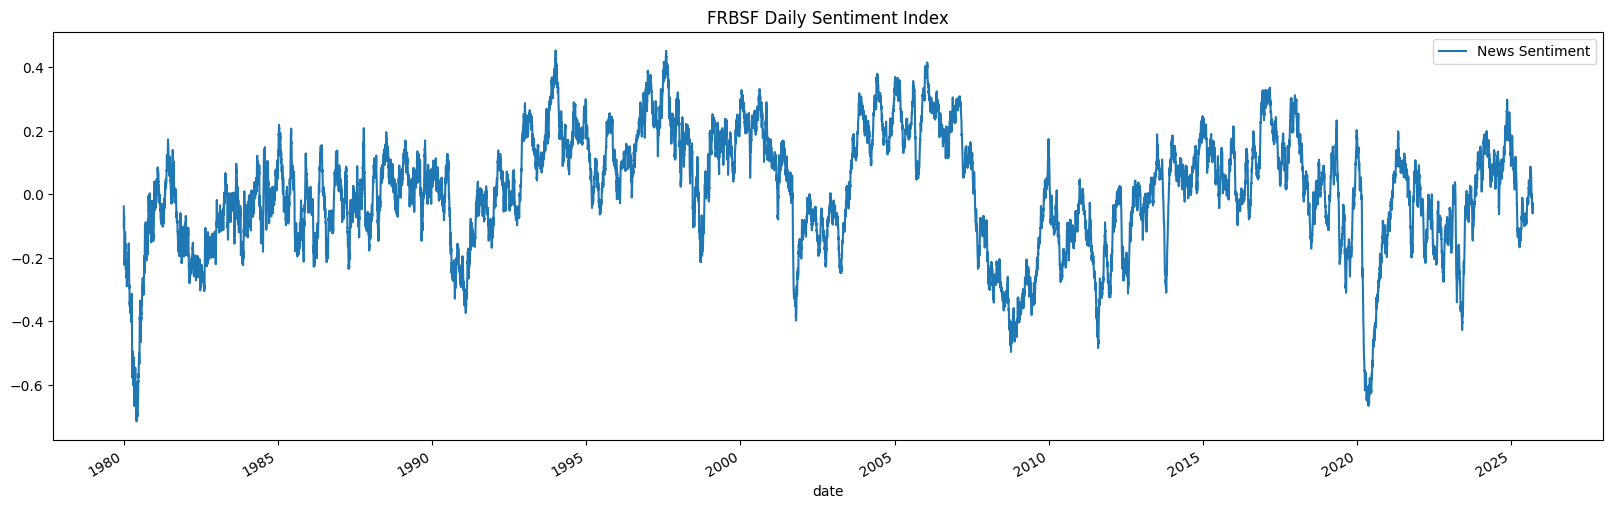

In [8]:
dsi.plot(title="FRBSF Daily Sentiment Index", figsize=(20,6))
plt.show()

**Plotting Daily Returns:**

Sharp spikes in the resturns could be examined to understand effects of these larger than normal movements on prices/yields.

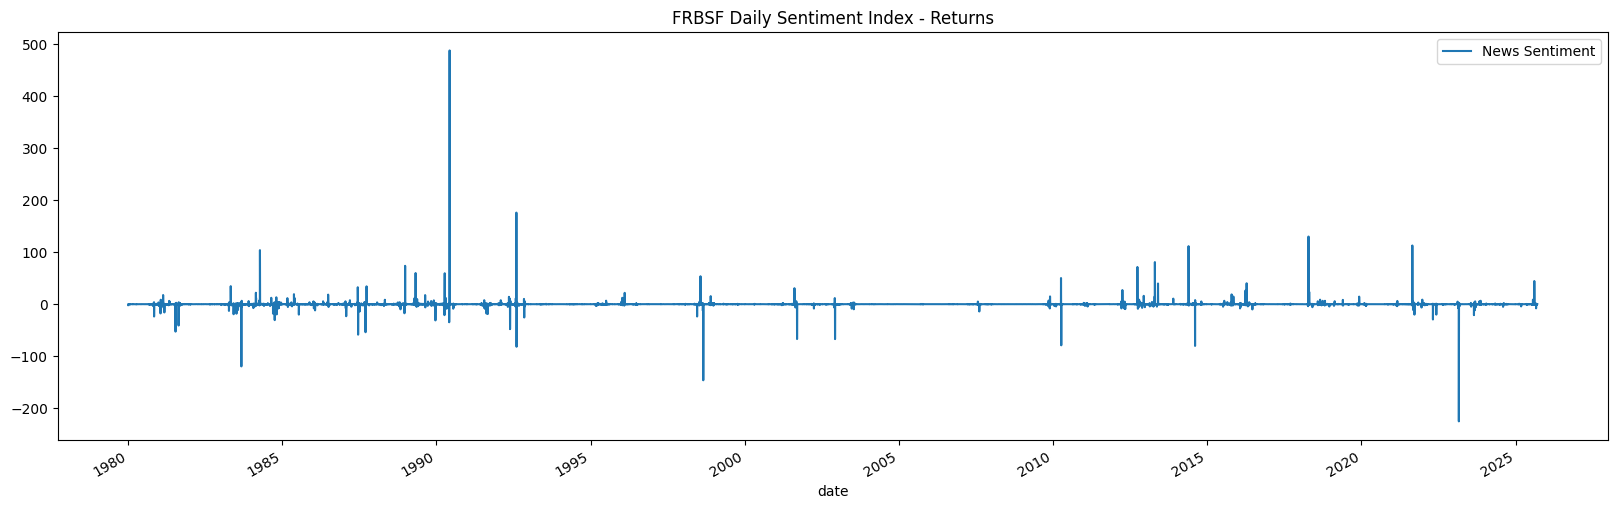

In [9]:
dsi_pct_chg = (dsi.diff()/dsi.shift(1).abs()).dropna()
dsi_pct_chg.plot(title="FRBSF Daily Sentiment Index - Returns", figsize=(20,6))
plt.show()

**Stationarity**

Stationarity is always important when analysing and modelling financial time series.  This section checks for stationarity, which may be relevant in future analysis.

The results show that overall, daily returns appear stationary. However, shorter periods of analysis might exhibit different characteristics.

In [10]:
from statsmodels.tsa.stattools import adfuller as adf
dsi_adf      =  adf(dsi['News Sentiment'])
dsi_rets_adf = adf(dsi_pct_chg['News Sentiment'].dropna())
print( f"The Daily Index ADF Statistic is {dsi_adf[0]}")
print( f"The Daily Index ADF Returns Statistic is {dsi_rets_adf[0]}")

print( f"\nThe Daily Index ADF p-value is {dsi_adf[1]}.This appears to be {'Stationary' if  dsi_adf[1] < 0.05 else 'Non-Stationary'} for the full duration.")
print( f"The Daily Index ADF Returns p-value is {dsi_rets_adf[1]}. This appears to be {'Stationary' if  dsi_rets_adf[1] < 0.05 else 'Non-Stationary'} for the full duration.")

The Daily Index ADF Statistic is -6.202694527832582
The Daily Index ADF Returns Statistic is -60.70833492217262

The Daily Index ADF p-value is 5.755853095001692e-08.This appears to be Stationary for the full duration.
The Daily Index ADF Returns p-value is 0.0. This appears to be Stationary for the full duration.


#Using the Federal Reserve News Data Only

1. Ingest the news data.
2. Use lexicon based method similar to that used by the FRBSA to calculate a score.
3. Examine results.

###**Data Ingestion**

In [32]:
sentiment_dir = f'{main_path}/Sentiment_Data'

press_releases_dir = f'{sentiment_dir}/FED_NEWS/News/press_releases/press_releases.parquet'
testimonies_dir    = f'{sentiment_dir}/FED_NEWS/News/testimony/testimonies.parquet'
speeches_dir       = f'{sentiment_dir}/FED_NEWS/News/speeches/speeches.parquet'

In [15]:
press_releases = pd.read_parquet(press_releases_dir)
testimonies    = pd.read_parquet(testimonies_dir)
speeches       = pd.read_parquet(speeches_dir)

In [16]:
press_releases.head(3)

,date,release_time,title,link,text
0,2025-08-19,For release at 11:00 a.m. EDT,Federal Reserve Board issues enforcement actio...,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve Board on Tuesday announced...
1,2025-08-15,For release at 12:00 p.m. EDT,Federal Reserve Board announces it will sunset...,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve Board on Friday announced ...
2,2025-08-12,For release at 11:00 a.m. EDT,Federal Reserve Board issues enforcement actio...,https://www.federalreserve.gov/newsevents/pres...,The Federal Reserve Board on Tuesday announced...


In [17]:
testimonies.head(3)

,date,location,speaker,title,link,text
0,2006-02-15,"Before the Committee on Financial Services, U....",Chairman Ben S. Bernanke,Semiannual Monetary Policy Report to the Congress,https://www.federalreserve.gov/newsevents/test...,Chairman Bernanke presented identical testimon...
1,2006-03-01,"Before the Committee on Banking, Housing, and ...",Governor Donald L. Kohn,Regulatory relief,https://www.federalreserve.gov/newsevents/test...,"Chairman Shelby, Senator Sarbanes, and members..."
2,2006-04-27,"Before the Joint Economic Committee, U.S. Cong...",Chairman Ben S. Bernanke,Outlook of the U.S. economy,https://www.federalreserve.gov/newsevents/test...,"Mr. Chairman and members of the Committee, I a..."


In [18]:
speeches.head(3)

,date,location,speaker,title,link,text
0,2006-01-18,Before the Tech Council of Maryland's Financia...,Governor Susan Schmidt Bies,Productivity and Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,I appreciate the opportunity to speak with you...
1,2006-02-02,"At the Financial Services Institute, Washingto...",Governor Susan Schmidt Bies,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,I thank you for the invitation to speak today....
2,2006-02-06,At the ceremonial swearing-in by President Bus...,Chairman Ben S. Bernanke,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,Good morning.\nI would like to begin by thanki...


####**Exploration with Word Clouds and Word Frequencies**

In [19]:
from wordcloud import STOPWORDS, WordCloud
import plotly.graph_objects as go
import re

#### Helper Functions

In [20]:
## remove stopwords and non-alpha chars
def prep_word_cloud_text( text_series, exclude_words=[]):

    #join the text to form one document
    text = ' '.join(text_series.tolist())
    ## remove non-alpha
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower()
    stopwords = set(STOPWORDS)
    # remove stopwords
    text = ' '.join([t for t in text.split() if t not in  stopwords and t not in exclude_words])
    return text


def plot_word_cloud( wc,
                     title,
                     interpolation = 'bilinear',
                     background_color = 'black',
                     figsize =(14,10)):

    # Display the generated image
    plt.figure(figsize=figsize)
    plt.imshow(wc, interpolation=interpolation)
    plt.axis('off')
    plt.title(title)
    plt.show()



def plotly_barh(x, y, title, height= 400, width=900):
    fig = go.Figure(go.Bar(
                x= x,
                y=y,
                orientation='h',
                ))

    fig.update_layout(
        title = title,
        yaxis={'categoryorder': 'total descending'},
        width=width,
        height=height
    )


    fig.show()


def plot_word_visuals( text_series    ,
                      wc_title        ,
                      exclude_words   ,
                      barchart_title  ,
                      wc_width        = 900,
                      wc_height       = 400,
                      wc_bg_color     = 'black' ,
                      barchart_top_n  = 20

                       ):

    exclude_words = [] if exclude_words is None  else exclude_words
    text = prep_word_cloud_text( text_series = text_series , exclude_words=exclude_words)
    wc = WordCloud( width=wc_width, height=wc_height, background_color=wc_bg_color ).generate(text)
    plot_word_cloud( wc,
                        title = wc_title,
                        interpolation = 'bilinear',
                        background_color = wc_bg_color,
                        figsize =(10,6)
    )

    terms = sorted( wc.words_.items(), key = lambda item: item[1], reverse=True )
    terms = dict(terms)
    plotly_barh( x= list(terms.values())[0:barchart_top_n],
                 y= list(terms.keys())[0: barchart_top_n],
                 title = barchart_title  + f'(Top - {barchart_top_n})'
              )

####Word Cloud for Titles

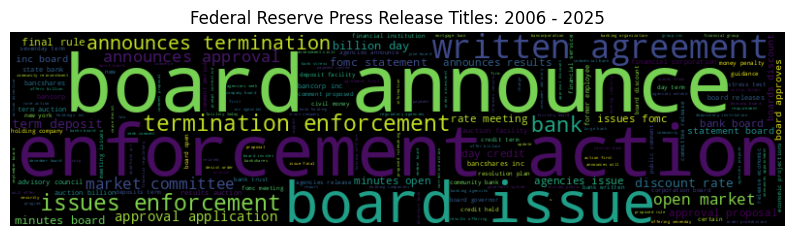

In [22]:
# @title Press Releases


plot_word_visuals( text_series    = press_releases['title'],
                      wc_title        = 'Federal Reserve Press Release Titles: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve'],
                      barchart_title  =  'Term Frequency - Fed Press Release- Titles',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

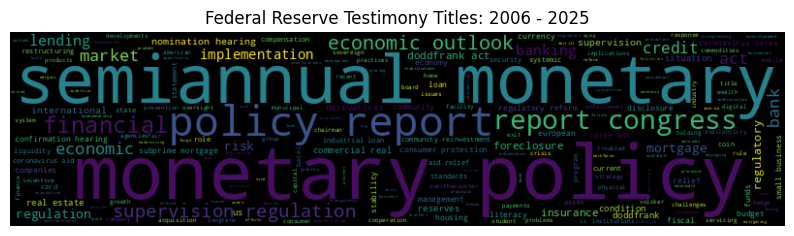

In [23]:
# @title Testimonies

plot_word_visuals( text_series        = testimonies['title'],
                      wc_title        = 'Federal Reserve Testimony Titles: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve'],
                      barchart_title  =  'Term Frequency - Testimony - Titles',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

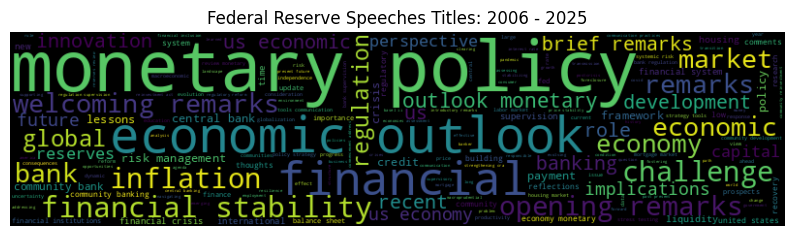

In [24]:
# @title Speeches

plot_word_visuals( text_series        = speeches['title'],
                      wc_title        = 'Federal Reserve Speeches Titles: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve'],
                      barchart_title  =  'Term Frequency - Speeches - Titles',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

####Word Cloud Bodies:



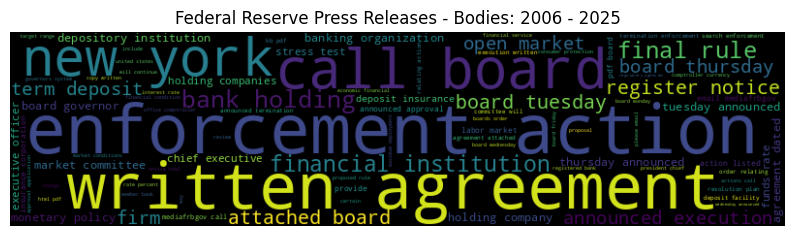

In [ ]:

# @title  Press Releases

plot_word_visuals( text_series        = press_releases['text'],
                      wc_title        = 'Federal Reserve Press Releases - Bodies: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve', 'media', 'inquiries'],
                      barchart_title  =  'Term Frequency - Press Releases - Bodies',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

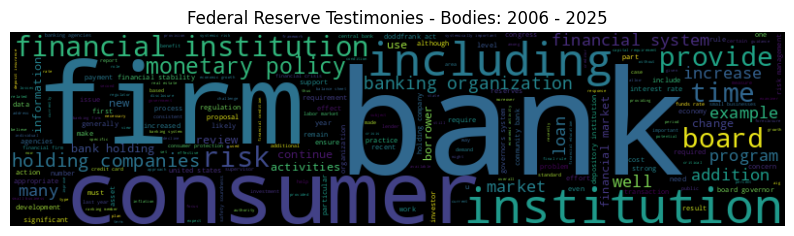

In [25]:
# @title  Testimonies

plot_word_visuals( text_series        = testimonies['text'],
                      wc_title        = 'Federal Reserve Testimonies - Bodies: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve', 'may', 'will', 'text', 'return'],
                      barchart_title  =  'Term Frequency - Testimonies - Bodies',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

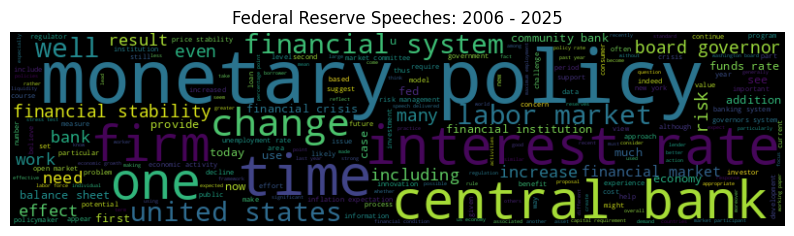

In [ ]:
# @title  Speeches

plot_word_visuals( text_series        = speeches['text'],
                      wc_title        = 'Federal Reserve Speeches: 2006 - 2025',
                      exclude_words   = ['federal', 'reserve', 'may', 'will', 'text', 'return', 'example'],
                      barchart_title  =  'Term Frequency - Speeches - Bodies',
                      wc_width        = 800,
                      wc_height       = 200,
                      wc_bg_color     = 'black'

                )

####**Calculation of Senitiment on Press Releases**

**This follows the methods used by the Federal Reserve Bank of San Francisco to calculate the Daily/Monthly Sentiment Index**

- Based on Loghran McDonald 2016 Lexicon combined with the Bing Liu Opinion Lexicon.

-  The Loghran-McDonald 2016 Lexicon is a lexicon designed for financial texts. An example given in the paper is that the word **liability** does not always have negative connotations in a finance context, while it is almost always negative in general language.

- The team found that combining Loghran-McDonald 2016 lexicon with the Bing Liu Opinion lexicon gave sentiment scores that closer resembled human annotations.  The Bing Liu is a sentiment analysis and opinion mining lexicon.

- The implementation in this notebook adjusted the code provided by FRBSF to work with text from Pandas Data Frames. It was originally designed to work with .txt files. A custom list of negation words was also added because the original VADER function used for Negation words appears to no longer exist.


The Sentiment Score is based on a Pointwise Mutual Information (PMI), calculated as :


  $log(p(w,c)/p(w)p(c))$


where

- $p(w,c)$ is the joint probability of the word appearing in the corpus $p(w)$ and the probability of a sentence containing the word in the corpus $p(c)$.

-   This quantifies a word's effect on a sentence, i.e. , does it become more, less or just as likely to make the sentence positive.

- Ultimately, this leads to an overall sentiment score for each word, calculated as:

    $S(w) = PMI(w,poitive) - PMI(w,negative)$

    **normalized to fall between  -1 and +1**





In [34]:
import os
frbsf_replication_dir = f'{main_path}/Sentiment_Data/news_sentiment_replication_code'
os.environ['LEXICON_DIR']  = frbsf_replication_dir
os.environ['FUNCTION_DIR'] = frbsf_replication_dir
os.environ['DATA_DIR']     = frbsf_replication_dir
os.environ['OUTPUT_DIR']   = frbsf_replication_dir



In [35]:
# @title Sentiment Helper Functions
def sentiment_by_record( path, doc_type):
  """
  Calculates sentiment scores and saves to df
  """
  os.environ['DF_PATH']      = path
  doc_type = doc_type

  ## run python script to calculate sentiment and save output as file
  !python   {sentiment_dir}/news_sentiment_replication_code/main_NS_score.py  --doc_type={doc_type}

def sentiment_results(doc_type):
  sentiment_df = pd.read_parquet(os.path.join(os.environ['OUTPUT_DIR' ],  f'{doc_type}_scores.parquet'))
  return sentiment_df

In [36]:
import time
paths     = [ press_releases_dir, testimonies_dir, speeches_dir]
doc_types = ['press_release', 'testimony', 'speech']

for doc_paths in zip( paths, doc_types):

  print(f'\n=========== {doc_paths[1]}==========')
  sentiment_by_record(path=doc_paths[0], doc_type= doc_paths[1])
  time.sleep(1)



=========== press_release==========
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Unzipping corpora/opinion_lexicon.zip.
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
DOC_TYPE : press_release

=========== testimony==========
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
DOC_TYPE : testimony

=========== speech==========
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
[nltk_data] Downloading package opinion_lexicon to /root/nltk_data...
[nltk_data]   Package opinion_lexicon is already up-to-date!
DOC_TYPE : speech


In [37]:
press_release_df = sentiment_results('press_release')
testimony_df = sentiment_results('testimony')
speeches_df = sentiment_results('speech')

In [43]:
press_release_df.head(3)

,date,title,link,sentiment,prepped_text
0,2025-08-19,Federal Reserve Board issues enforcement actio...,https://www.federalreserve.gov/newsevents/pres...,0.000457,The Federal Reserve Board on Tuesday announced...
1,2025-08-15,Federal Reserve Board announces it will sunset...,https://www.federalreserve.gov/newsevents/pres...,-0.061696,The Federal Reserve Board on Friday announced ...
2,2025-08-12,Federal Reserve Board issues enforcement actio...,https://www.federalreserve.gov/newsevents/pres...,0.014817,The Federal Reserve Board on Tuesday announced...


In [44]:
testimony_df.head(3)

,date,title,link,sentiment,prepped_text
0,2006-02-15,Semiannual Monetary Policy Report to the Congress,https://www.federalreserve.gov/newsevents/test...,-0.073067,Chairman Bernanke presented identical testimon...
1,2006-03-01,Regulatory relief,https://www.federalreserve.gov/newsevents/test...,-0.049182,"Chairman Shelby, Senator Sarbanes, and members..."
2,2006-04-27,Outlook of the U.S. economy,https://www.federalreserve.gov/newsevents/test...,-0.070863,"Mr. Chairman and members of the Committee, I a..."


In [45]:
speeches_df.head(3)

,date,title,link,sentiment,prepped_text
0,2006-01-18,Productivity and Economic Outlook,https://www.federalreserve.gov/newsevents/spee...,-0.101982,I appreciate the opportunity to speak with you...
1,2006-02-02,The Continuous Challenges of Risk Management,https://www.federalreserve.gov/newsevents/spee...,-0.004585,I thank you for the invitation to speak today....
2,2006-02-06,Remarks at ceremonial swearing-in by President...,https://www.federalreserve.gov/newsevents/spee...,-0.256836,Good morning.\nI would like to begin by thanki...


In [46]:
press_release_df = press_release_df.sort_values(by = 'date',  ascending=True).reset_index( drop=True)
testimony_df     = testimony_df.sort_values(by = 'date',  ascending=True).reset_index( drop=True)
speeches_df      = speeches_df.sort_values(by = 'date',  ascending=True).reset_index( drop=True)

In [48]:
#@title Charting Function
import plotly.express as px
import plotly.io as pio

def plotly_bar_chart(df, y_col_name, title, line_color, bg_color, image_folder):
    # Create the line chart
    fig = px.bar(df,
                 x=df.index,
                 y=y_col_name,
                 title= title,
                )

    # Update the layout for a white plot background
    fig.update_layout(
        plot_bgcolor=bg_color
    )

    # Update the traces to set a dark color for the bars
    fig.update_traces(
        marker_color=line_color,
        marker_line_width=0 # A dark gray color
    )

    fig.update_xaxes(
    mirror=True,
    ticks='outside',
    showline=True,
    linecolor='black',
    gridcolor='lightgrey'
    )
    fig.update_yaxes(
      mirror=True,
      ticks='outside',
      showline=True,
      linecolor='black',
      gridcolor='lightgrey'
    )

    if image_folder is not None:
      ## to prevent accidental ovewrite
      now = datetime.now().strftime('%Y%m%d%H%M%S%f')
      fig.write_image(f"/{image_folder}/{title.lower().replace(' ', '_').replace( '-', '')}_{now}.png", scale= 5)

    fig.show()

In [50]:
#@title Press Releases

pr_df_agg = press_release_df[['date', 'sentiment']].groupby('date').agg({'sentiment' : 'mean'})
plotly_bar_chart(pr_df_agg,
                 y_col_name = 'sentiment',
                 title = 'FRBSF Sentiment Index - FED Press Releases' ,
                 line_color = 'navy',
                 bg_color = 'white',
                 image_folder = None)

In [51]:
#@title Testimony
testimony_df_agg = testimony_df[['date', 'sentiment']].groupby('date').agg({'sentiment' : 'mean'})

plotly_bar_chart(testimony_df_agg,
                 y_col_name = 'sentiment',
                 title      = 'FRBSF Sentiment Index - FED Testimony' ,
                 line_color = 'navy',
                 bg_color   = 'white',
                 image_folder = None)

In [52]:
#@title Speeches

speeches_df_agg = speeches_df[['date', 'sentiment']].groupby('date').agg({'sentiment' : 'mean'})

plotly_bar_chart(speeches_df_agg,
                 y_col_name = 'sentiment',
                 title      = 'FRBSF Sentiment Index - FED Speeeches' ,
                 line_color = 'navy',
                 bg_color   = 'white',
                 image_folder = None)

In [ ]:
## Best  - Sanity Check
print("**The higher the sentiment score the more positive the implied effect on treasury prices.**")
upper = press_release_df.sentiment.quantile(0.95)
lower = press_release_df.sentiment.quantile(0.05)
print( '\n======Press Release Titles for Full Articles with Highest Sentiment Scores====')
print(press_release_df.loc[press_release_df.sentiment > upper].sort_values(by="sentiment", ascending=False)['title'].values[0:10])

upper = testimony_df.sentiment.quantile(0.95)
lower = testimony_df.sentiment.quantile(0.05)
print( '\n======Testimony Titles for Full Articles with  Highest Sentiment Scores====')
print(testimony_df.loc[testimony_df.sentiment > upper].sort_values(by="sentiment", ascending=False)['title'].values[0:10])

upper = speeches_df.sentiment.quantile(0.95)
lower = speeches_df.sentiment.quantile(0.05)
print( '\n =====Speech Title for Full Articles  with Highest Sentiment Scores====')
print(speeches_df.loc[speeches_df.sentiment > upper].sort_values(by="sentiment", ascending=False)['title'].values[0:10])

**The higher the sentiment score the more positive the implied effect on treasury prices.**

======Press Release Titles for Full Articles with Highest Sentiment Scores====
['Termination of enforcement action against Citigroup Inc.'
 'Termination of enforcement action against Canadian Imperial Bank of Commerce'
 'Federal Reserve Board issues enforcement action with former employee of Centennial Bank'
 'Federal Reserve Board permanently bars two former employees of Regions Bank from the banking industry'
 'Federal Reserve Board issues revised macroeconomic scenarios for its 2017 stress testing program to correct a data series error'
 'Order of assessment of civil money penalty against John Price'
 'Agencies issue statement on elder financial exploitation'
 'Order of prohibition against Matthew Censoplano'
 'Federal Reserve Board releases hypothetical scenarios for its 2022 bank stress tests'
 'Federal Reserve issues full corrected results for the 2014 Dodd-Frank Act stress test']

======

In [54]:
## Worst - Sanity Check
print("**The lower the sentiment score the more negative the implied effect on treasury prices.**")
print( '\n======Press Release Titles for Full Articles with Lowest Sentiment Scores====')
print(press_release_df.loc[press_release_df.sentiment < lower].sort_values(by="sentiment", ascending=False)['title'].values[-10:])

print( '\n======Testimony Titles for Full Articles with Lowest Sentiment Scores====')
print(testimony_df.loc[testimony_df.sentiment < lower].sort_values(by="sentiment", ascending=False)['title'].values[-10:])

print( '\n =====Speech Title for Full Articles  with Lowest Sentiment Scores====')
print(speeches_df.loc[speeches_df.sentiment < lower].sort_values(by="sentiment", ascending=False)['title'].values[-10:])


**The lower the sentiment score the more negative the implied effect on treasury prices.**

======Press Release Titles for Full Articles with Lowest Sentiment Scores====
['Statement by Chairman Bernanke on his renomination by President Obama'
 'Statement by Federal Reserve Board Vice Chair Yellen on her nomination by President Obama'
 'Federal Reserve Board announces approval of application by Home BancShares, Inc.'
 'Statement by Chairman Bernanke regarding Secretary Snow'
 'Statement by Governor Bowman'
 'Written agreement with Great River Bank & Trust'
 'Federal Reserve Board announces plans to present Janet L. Yellen Award for Excellence in Community Development'
 'Statement by Chairman Bernanke on agreement by the Congress and the Administration'
 'Late Governor Gramlich honored with Lifetime Achievement Award for Responsible Finance'
 "Statement by Chair Yellen on U.S. Treasury's currency redesign announcement"]

======Testimony Titles for Full Articles with Lowest Sentiment Scor

**So far, the results are not very convicing and sometimes appear contradictory. The next section will  take a large language model approach.**

However, future work could explore whether customizing or creating a new lexicon targeted specifically to U.S. Treasury Securities will lead to more consistent results.